In [45]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [46]:
# Import packages

# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from sklearn.impute import KNNImputer

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler

# Test
from sklearn.linear_model import Ridge

In [47]:
# preprocessing function

def data_preprocessing(X_train, y_train):
    '''Data preprocessing'''

    # 1. Scaling (standard, min max, robust)

    # Scale the data to be normal
    #scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    # scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    # 2. Feature selection/extraction
    # Create the Recursive Feature Elimination object and compute a cross-validated score.
    #svc = svm.SVC(kernel="linear")
    clf = Ridge(alpha=1000000)

    # classifications
    rfecv = feature_selection.RFECV(
        estimator=clf, step=1, 
        cv=model_selection.StratifiedKFold(4),
        scoring='roc_auc')
    rfecv.fit(X_train_scaled, y_train)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    print("Optimal number of features : %d" % rfecv.n_features_)

    # 3. PCA
    n_selected_features = rfecv.n_features_
    n_samples = len(X_train.index)
    n_components = min(n_samples, n_selected_features)
    pca = decomposition.PCA(n_components)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)

    # print(X_train_pca)
    # X_train_pca.shape

    # # 4. Imputation missing data
    # missing_values=[0.0, 1.0]
    # for elem in missing_values:
    #     imputer = KNNImputer(missing_values=elem, n_neighbors=5, weights='uniform')
    #     X_train_imputed = imputer.fit_transform(X_train_pca)

    # print(X_train_imputed)
    # X_train_imputed.shape

    return X_train_pca

The number of samples: 113
The number of features: 159


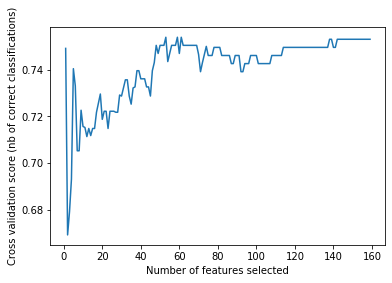

Optimal number of features : 53


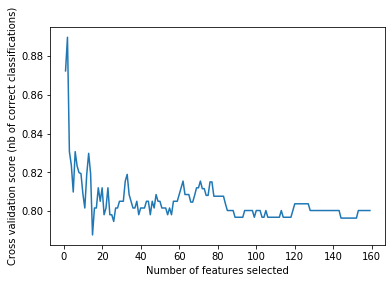

Optimal number of features : 2


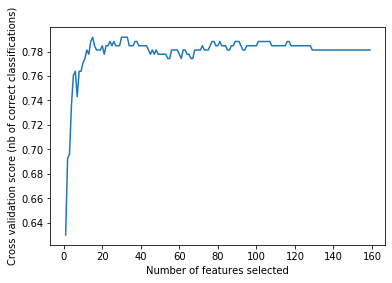

Optimal number of features : 30


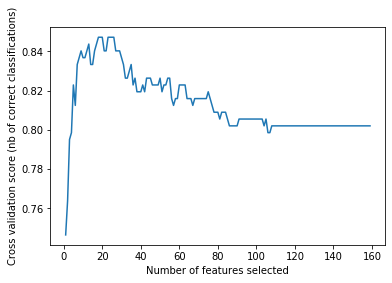

Optimal number of features : 18


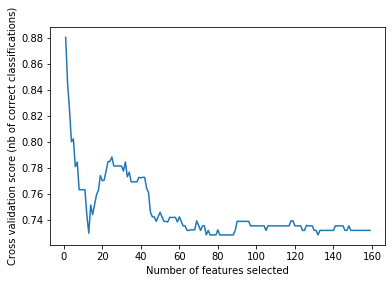

Optimal number of features : 1


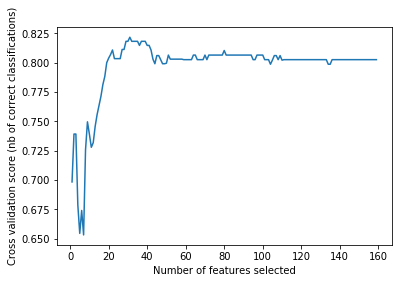

Optimal number of features : 31


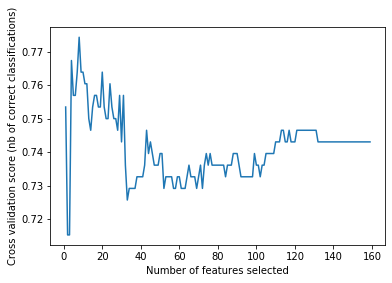

Optimal number of features : 8


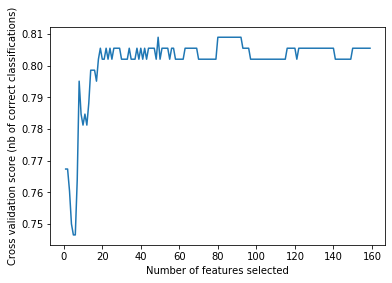

Optimal number of features : 49


In [48]:
# Data splitting

# # Data imputation (NOG OP VERKEERDE PLEK) --> niet meer nodig
# split_X_train[split_X_train == 1] = np.nan
# split_X_train[split_X_train == 0.0] = np.nan

# for column in split_X_train:
#     print(column)
#     print(split_X_train[column].isnull().sum(axis = 0))

# Data loading
from hn.load_data import load_data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

sss = model_selection.StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=None)
cv_4fold = model_selection.StratifiedKFold(n_splits=4)

count = 0 
for train_index, test_index in sss.split(data, y):
    train_scores = []
    test_scores = []
    count += 1
    #print(f'Iteration {count}')
    data_array = pd.DataFrame.from_dict(data) #Needed to be able to index this later 
    split_X_train = data_array.iloc[train_index]
    split_y_train = y[train_index]
    split_X_test = data_array.iloc[test_index]
    split_y_test = y[test_index]
    #print(f'Training dataset size {len(split_X_train)}')
    #print(f'Test dataset size {len(split_X_test)}')

    # Loop over the folds
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]
        #print(f'Validation size in current fold = {len(X_validation)}')
        
        #apply preprocessing
        X_train_pca = data_preprocessing(X_train, y_train)

        #print(X_train)